<a href="https://colab.research.google.com/github/kvamsi7/Text-Generation/blob/main/project_text_generation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#download the data and save it to poem.txt
# using a the book from the gutenberg.org 

!wget https://www.gutenberg.org/files/1661/1661-0.txt -O book.txt

--2021-08-11 19:15:57--  https://www.gutenberg.org/files/1661/1661-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607430 (593K) [text/plain]
Saving to: ‘book.txt’

book.txt            100%[===================>] 593.19K  1.72MB/s    in 0.3s    

2021-08-11 19:15:58 (1.72 MB/s) - ‘book.txt’ saved [607430/607430]



In [2]:
#read the file in text string
text = open('book.txt', 'r', encoding='utf-8').read()
text = text.lower()

Have a look over the text once 

In [6]:
text[:1000]

'\ufeffthe project gutenberg ebook of the adventures of sherlock holmes, by arthur conan doyle\n\nthis ebook is for the use of anyone anywhere in the united states and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever. you may copy it, give it away or re-use it under the terms\nof the project gutenberg license included with this ebook or online at\nwww.gutenberg.org. if you are not located in the united states, you\nwill have to check the laws of the country where you are located before\nusing this ebook.\n\ntitle: the adventures of sherlock holmes\n\nauthor: arthur conan doyle\n\nrelease date: november 29, 2002 [ebook #1661]\n[most recently updated: may 20, 2019]\n\nlanguage: english\n\ncharacter set encoding: utf-8\n\nproduced by: an anonymous project gutenberg volunteer and jose menendez\n\n*** start of the project gutenberg ebook the adventures of sherlock holmes ***\n\ncover\n\n\n\n\nthe adventures of sherlock holmes\n\nby arthur conan doyle\n\n

In [7]:
#create list of sentences
sentences = text.split('\n')

In [8]:
# import the dependencies to preprocess the text data and making sequences

import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [32]:
#initialize the tokenizer, which can work char by char
tokenizer = Tokenizer(oov_token='<UNK>',char_level=False)

In [33]:
tokenizer.fit_on_texts(sentences)

In [35]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8915

In [36]:
sequences = tokenizer.texts_to_sequences(sentences)

In [38]:
input_sequences = []
for sequence in sequences:
  for i in range(1, len(sequence)):
    n_gram_sequence = sequence[:i+1]
    # print(n_gram_sequence)
    input_sequences.append(n_gram_sequence)

In [39]:
print(input_sequences[0], input_sequences[1], input_sequences[2], input_sequences[3])

[4775, 145] [4775, 145, 132] [4775, 145, 132, 886] [4775, 145, 132, 886, 5]


In [42]:
#find the maximum length among sequences
max_seq_len = max([len(seq) for seq in input_sequences])
max_seq_len

20

In [ ]:
#we will keep the last value of the sequence as our target label and all values before that as input to sequence model

In [43]:
#pad the sequences to ensure that they are all of same length
padded_sequences = pad_sequences(input_sequences, maxlen = max_seq_len)

In [ ]:
print(padded_sequences[0], padded_sequences[1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 4775  145] [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 4775  145  132]


In [44]:
import numpy as np
padded_sequences = np.array(padded_sequences)

In [54]:
# sparse representation
# input = padded_sequences[:,0:-1] # will keep the all values as input but last column
# labels = padded_sequences[:,-1] # keeping last column values as labels

In [ ]:
print(len(padded_sequences[0]))
print(len(padded_sequences[1]))

20
20


In [55]:
#prepare training sequences and labels
x = padded_sequences[:, : -1]
labels = padded_sequences[:, -1]

In [56]:
labels.shape

(101575,)

In [57]:
#to one hot encode the labels
y = tf.keras.utils.to_categorical(labels, num_classes=vocab_size) # since discrete variables

In [60]:
x.shape

(101575, 19)

In [ ]:
#x = x.reshape(x.shape[0], x.shape[1], 1)

In [ ]:
y.shape

(101575, 8915)

In [61]:
# importing dependencies for defining the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Bidirectional,LSTM,Dense
from tensorflow.keras.optimizers import Adam

In [79]:
model = Sequential()
model.add(Embedding(vocab_size,100,input_length=max_seq_len-1))
model.add(Bidirectional(LSTM(256)))
model.add(Dense(vocab_size,activation='softmax'))
adam = Adam(learning_rate=0.01)


model.compile(loss='categorical_crossentropy',optimizer=adam,metrics='acc')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 19, 100)           891500    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               731136    
_________________________________________________________________
dense_1 (Dense)              (None, 8915)              4573395   
Total params: 6,196,031
Trainable params: 6,196,031
Non-trainable params: 0
_________________________________________________________________


In [80]:
#initialize the callback for early stopping the training if there is not at least 1% improvement in the accuracy 
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'acc', min_delta=0.05)

In [82]:
history = model.fit(x, y, epochs=20, verbose=1, batch_size=512,callbacks=[es])

Epoch 1/20
199/199 [==============================] - 9s 44ms/step - loss: 5.3298 - acc: 0.1409
Epoch 2/20
199/199 [==============================] - 9s 44ms/step - loss: 4.7892 - acc: 0.1714
Epoch 3/20
199/199 [==============================] - 9s 44ms/step - loss: 4.2685 - acc: 0.2007
Epoch 4/20
199/199 [==============================] - 9s 45ms/step - loss: 3.7593 - acc: 0.2466
Epoch 5/20
199/199 [==============================] - 9s 45ms/step - loss: 3.3044 - acc: 0.2980
Epoch 6/20
199/199 [==============================] - 9s 44ms/step - loss: 2.9240 - acc: 0.3528
Epoch 7/20
199/199 [==============================] - 9s 45ms/step - loss: 2.6093 - acc: 0.4050
Epoch 8/20
199/199 [==============================] - 9s 45ms/step - loss: 2.3550 - acc: 0.4494
Epoch 9/20
199/199 [==============================] - 9s 45ms/step - loss: 2.1407 - acc: 0.4900
Epoch 10/20
199/199 [==============================] - 9s 44ms/step - loss: 1.9688 - acc: 0.5235
Epoch 11/20
199/199 [==================

In [83]:
#Time to become storyteller!
seed_text = "I could not help laughing at the ease with which he explained his process of deduction"          
next_words = 100
  
for _ in range(next_words):
  sequence = tokenizer.texts_to_sequences([seed_text])
  padded = pad_sequences(sequence, maxlen=max_seq_len-1)
  predicted = model.predict_classes(padded, verbose=0)
  output_word = ''
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += ' ' + output_word
print(seed_text)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


I could not help laughing at the ease with which he explained his process of deduction into me for his hand he had a great good a gentleman with which i could not help the truth the reason easier to you lestrade ” drawled holmes up his head on his hand and a with a gesture of a man who is very much superior to the very strong language to his son and he was very kind in it and was the only thought so of the very fact that i am ready to find a little more i will leave in the city again but i can not ask it to you the name of


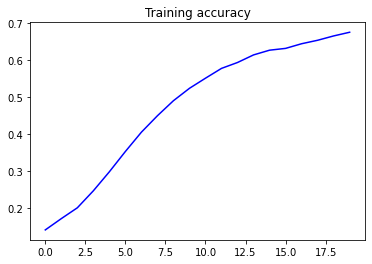

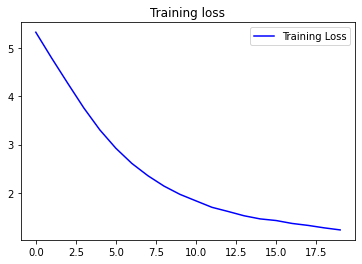

In [84]:
#let's look at how loss and accuracy changed while training
import matplotlib.pyplot as plt
# history = model.history
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()